# Bike Sharing in Washington D.C. with Dask

Two datasets from [Bike Sharing in Washington D.C.](https://www.kaggle.com/marklvl/bike-sharing-dataset/home) containing information about the Bike Sharing service in Washington D.C. "Capital Bikeshare" are provided.

One dataset contains hourly data and the other one has daily data from the years 2011 and 2012.

The following variables are included in the data:

* instant: Record index
* dteday: Date
* season: Season (1:springer, 2:summer, 3:fall, 4:winter)
* yr: Year (0: 2011, 1:2012)
* mnth: Month (1 to 12)
* hr: Hour (0 to 23, only available in the hourly dataset)
* holiday: whether day is holiday or not (extracted from Holiday Schedule)
* weekday: Day of the week
* workingday: If day is neither weekend nor holiday is 1, otherwise is 0.
* weathersit: (extracted from Freemeteo)
    1: Clear, Few clouds, Partly cloudy, Partly cloudy
    2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp: Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
* atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
* hum: Normalized humidity. The values are divided to 100 (max)
* windspeed: Normalized wind speed. The values are divided to 67 (max)
* casual: count of casual users
* registered: count of registered users
* cnt: count of total rental bikes including both casual and registered (Our target variable)

We will build a predictive model that can determine how many people will use the service on an hourly basis. We will use the first 5 quarters of the data for our training dataset and the last quarter of 2012 will be the holdout against which we perform our validation. Since that data was not used for training, we are sure that the evaluation metric that we get for it (R2 score) is an objective measurement of its predictive power.

### Outline

We separate the project in 3 steps:

Data Loading and Exploratory Data Analysis: Load the data and analyze it to obtain an accurate picture of it, its features, its values (and whether they are incomplete or wrong), its data types among others. Also, the creation of different types of plots in order to help us understand the data and make the model creation easier.

Feature Engineering / Pipeline and Hyperparameter Tuning: Once we have the data, we create some features and then create a pipeline with different transformers, we will hopefully produce a model that fits our expectations of performance. Once we have that model, a process of tuning it to the training data would be performed.

Results and Conclusions: Finally, with our tuned model, we  predict against the test set we decided to separate initially, then we review those results against their actual values to determine the performance of the model, and finally, outlining our conclusions.

In [1]:
import seaborn as sns
import dask.dataframe as dd
import matplotlib.pyplot as plt
from dask.distributed import Client
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from dask_ml.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from dask_ml.model_selection import RandomizedSearchCV
from dask_ml.preprocessing import OneHotEncoder, PolynomialFeatures

### Setting Key Values

The following values are used throught the code, this cell gives a central source where they can be managed.

In [2]:
PATH = 'https://gist.githubusercontent.com/akoury/af59a34ac7d3eb52fd78d6ead200f224/raw/f034e9dc2d2f62d82bbc685e499e48968b9db064/Bicycles.csv'
SPLITS = 4
METRIC = 'r2'
SEED = 1
TARGET = 'cnt'

### The Dataset

The necessary data was uploaded to a gist from where its read directly by Dask.

**Optionally** (because it requires more setup) you may download the data directly from Kaggle, this is the optimal way since you are sure to obtain the latest files if there are any changes.

In order to obtain the data from Kaggle using its API, you need to:
1. Install the kaggle package ```pip install kaggle```
2. [Create a Kaggle account](https://www.kaggle.com/account/login) if you do not have one
3. Create a Kaggle API key in your account section
4. Add the kaggle.json file that was created in step 3 to a folder called .kaggle located in your user folder

In [3]:
# import kaggle
# import zipfile

# kaggle.api.authenticate()
# kaggle.api.dataset_download_files('marklvl/bike-sharing-dataset', path='data', unzip=False)

Zipfile is required to unzip the kaggle file (since the unzip parameter in the ```dataset_download_files``` method is not working [Issue #158](https://github.com/Kaggle/kaggle-api/issues/158)).

In [4]:
# zipper = zipfile.ZipFile('data/bike-sharing-dataset.zip', 'r')
# zipper.extractall('data/')
# zipper.close()
# PATH = 'data/hour.csv'

Here we create the necessary Dask distributed client, you may click on the dashboard link to see the task stream and additional information.

In [5]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:53674 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


### Data Loading

Here we load the necessary data, print its first rows and describe its contents.

Since our dataset is small and we want to take advantage of the distributed capabilities of Dask, we set a blocksize of 300KB which distributes our code in 4 partitions.

In [6]:
types = {
    'season':'category',
    'yr':'category', 
    'mnth': 'category',
    'holiday' :'bool',
    'weekday': 'category',
    'workingday':'bool',
    'weathersit':'category',
}

df = dd.read_csv(PATH, parse_dates=[1], dtype=types, blocksize="300KB")
df.npartitions

4

### Precipitation Data and Preparation
We will add precipitation data obtained from the [National Climatic Data Center.](https://www.ncdc.noaa.gov/cdo-web/datasets)

However, since most of the values are 0, we will convert them to a boolean that determines if rain was present or not at that specific hour.

We also categorize the categorical features and set the date as the index.

In [7]:
precipitation = dd.read_csv("https://gist.githubusercontent.com/akoury/6fb1897e44aec81cced8843b920bad78/raw/b1161d2c8989d013d6812b224f028587a327c86d/precipitation.csv", parse_dates=[1])
df = dd.merge(df, precipitation, how="left", on=["dteday", "hr"])
df['precipitation'] = df['precipitation'].mask(df['precipitation'].isnull(), 0).mask(df['precipitation'] > 0, 1).astype(bool)
df = df.set_index('dteday')
df.head()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,precipitation
dteday,,,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,False,6,False,1,0.24,0.2879,0.81,0.0,3,13,16,True
2011-01-01,2,1,0,1,1,False,6,False,1,0.22,0.2727,0.80,0.0,8,32,40,True
2011-01-01,3,1,0,1,2,False,6,False,1,0.22,0.2727,0.80,0.0,5,27,32,True
2011-01-01,4,1,0,1,3,False,6,False,1,0.24,0.2879,0.75,0.0,3,10,13,True
2011-01-01,5,1,0,1,4,False,6,False,1,0.24,0.2879,0.75,0.0,0,1,1,True


Since we set the date as the index for the Dask Dataframe, each division will be sorted according to its date

In [8]:
df.divisions

(Timestamp('2011-01-01 00:00:00'),
 Timestamp('2011-06-16 13:26:24'),
 Timestamp('2011-12-30 00:00:00'),
 Timestamp('2012-06-14 00:00:00'),
 Timestamp('2012-12-31 00:00:00'))

### Data Types

We review the data types for each column.

In [9]:
df.dtypes

instant             int64
season           category
yr               category
mnth             category
hr                  int64
holiday              bool
weekday          category
workingday           bool
weathersit       category
temp              float64
atemp             float64
hum               float64
windspeed         float64
casual              int64
registered          int64
cnt                 int64
precipitation        bool
dtype: object

### Exploratory Data Analysis

Here we will perform all of the necessary data analysis, with different plots that will help us understand the data and therefore, create a better model.

Because we are working in a distributed way with a supposedly large dataset, we will take a random sample of 15% of the dataset to visualize it.

In [10]:
sample = df.sample(frac=0.15, replace=True, random_state=SEED)

### Overall distribution of the target variable

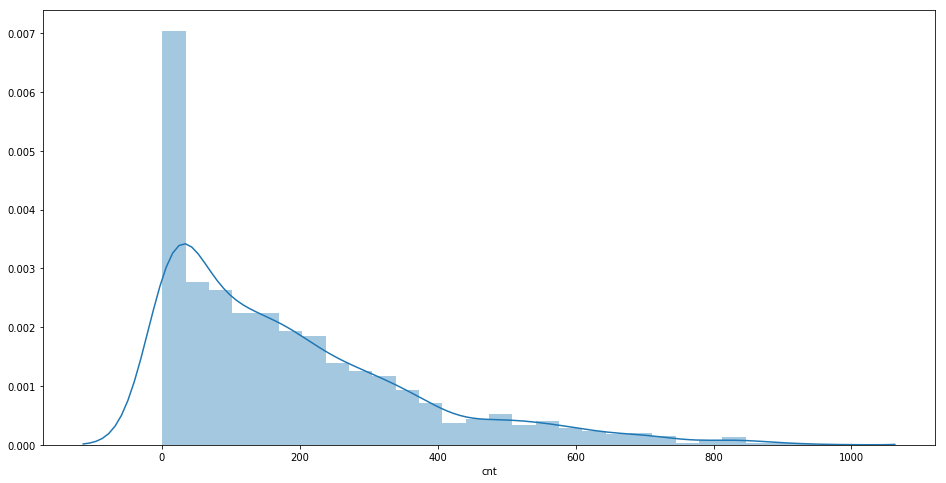

In [11]:
plt.figure(figsize=(16, 8))
sns.distplot(sample[TARGET])

### Usage per hour of the day by registered and casual users

Text(0, 0.5, 'Users')

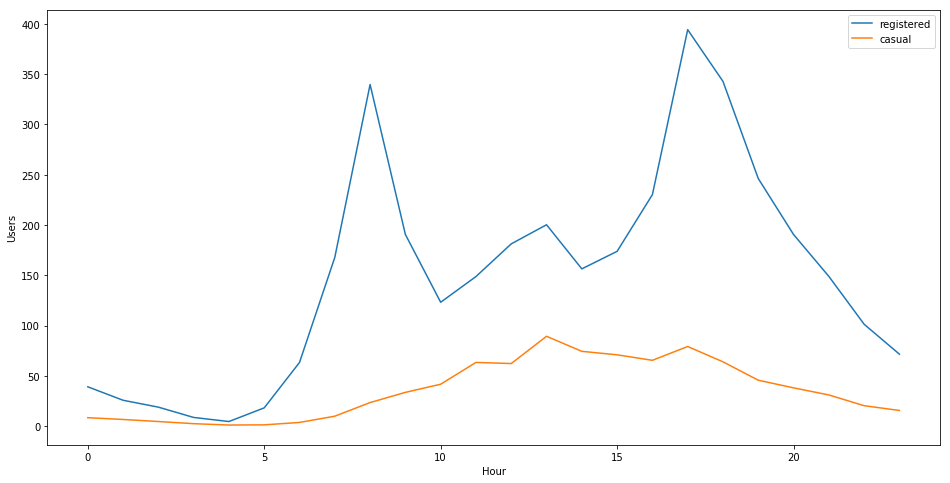

In [12]:
plt.figure(figsize=(16, 8))
grouped = sample.groupby('hr').agg({'registered': 'mean', 'casual': 'mean'}).reset_index().compute()
sns.lineplot(data=grouped, x="hr", y="registered", palette="husl", label="registered")
sns.lineplot(data=grouped, x="hr", y="casual", palette="husl", label="casual")
plt.xlabel("Hour")
plt.ylabel("Users")

### Usage per month by registered and casual users

Text(0, 0.5, 'Users')

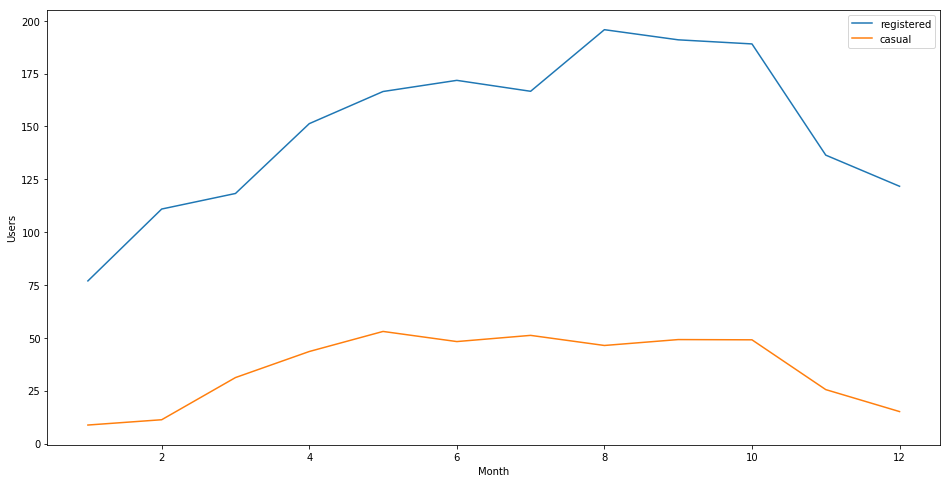

In [13]:
plt.figure(figsize=(16, 8))
sample['mnth'] = sample['mnth'].astype('int')
grouped = sample.groupby('mnth').agg({'registered': 'mean', 'casual': 'mean'}).reset_index().compute()
sns.lineplot(data=grouped, x="mnth", y="registered", palette="husl", label="registered")
sns.lineplot(data=grouped, x="mnth", y="casual", palette="husl", label="casual")
plt.xlabel("Month")
plt.ylabel("Users")

Text(0, 0.5, 'Users')

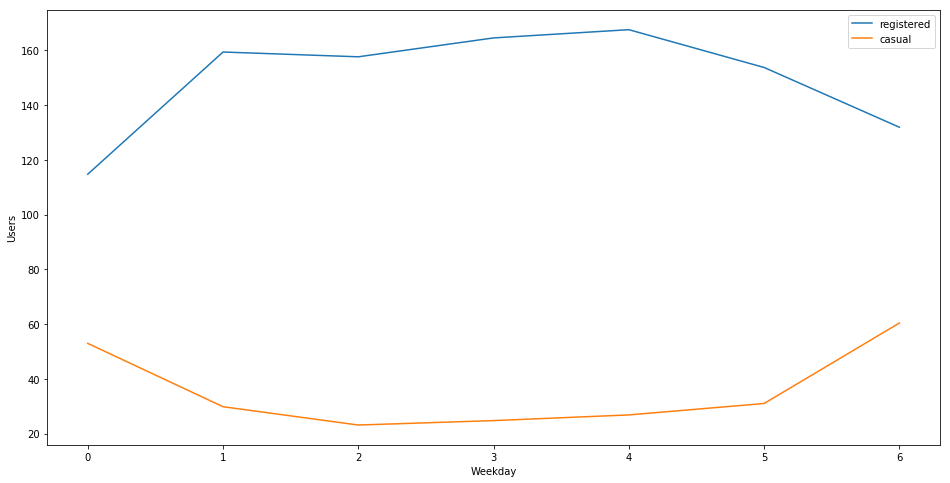

In [14]:
plt.figure(figsize=(16, 8))
sample['weekday'] = sample['weekday'].astype('int')
grouped = sample.groupby('weekday').agg({'registered': 'mean', 'casual': 'mean'}).reset_index().compute()
sns.lineplot(data=grouped, x="weekday", y="registered", palette="husl", label="registered")
sns.lineplot(data=grouped, x="weekday", y="casual", palette="husl", label="casual")
plt.xlabel("Weekday")
plt.ylabel("Users")

### Boxplot of Numerical Variables

We review the distribution of numerical data through a boxplot for each variable.

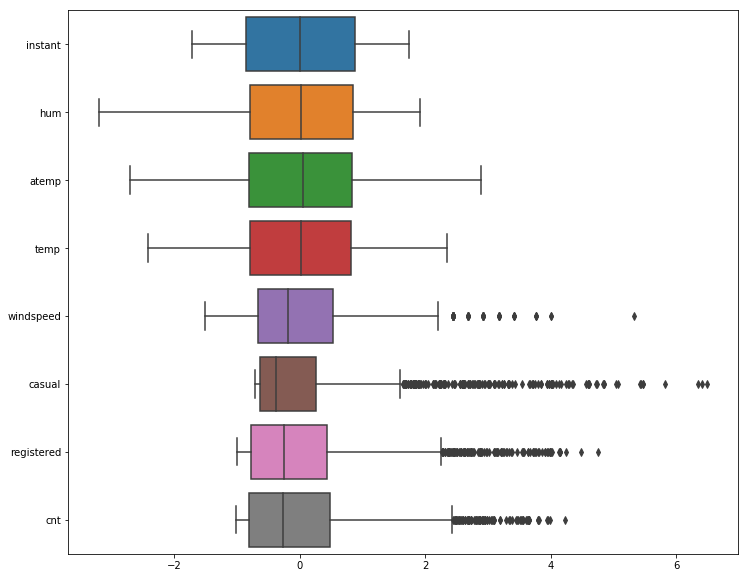

In [15]:
plt.figure(figsize=(12, 10))
numeric = sample[["instant", "hum", "atemp", "temp", "windspeed", "casual", "registered", "cnt"]].compute()
numeric = (numeric - numeric.mean()) / numeric.std()
sns.boxplot(data=numeric, orient="h")

### Data Correlation

Now we will analyze correlation in the data for all variables

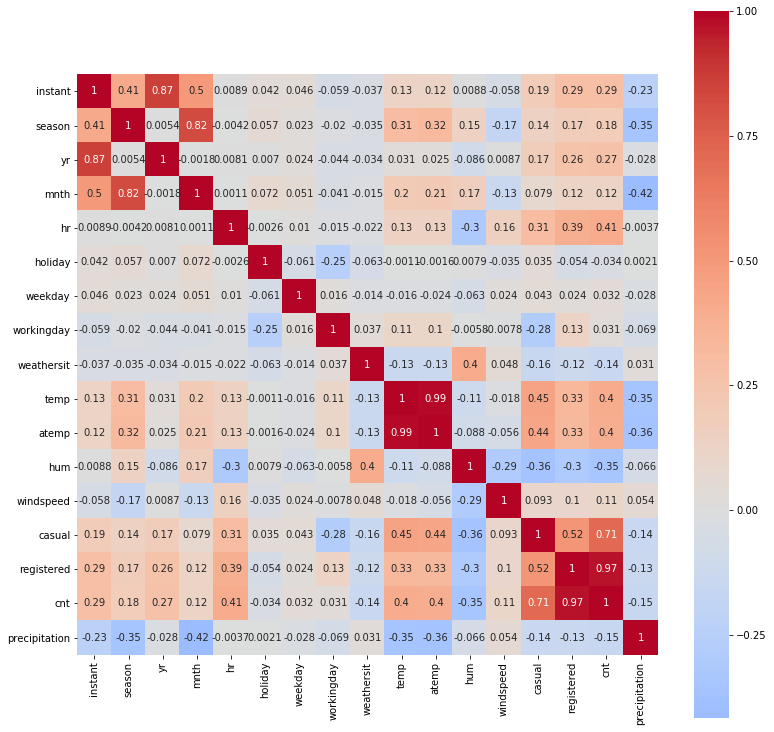

In [16]:
plt.figure(figsize=(13, 13))
sns.heatmap(sample.astype(float).corr(), cmap='coolwarm', center=0, square=True, annot=True, xticklabels=sample.columns, yticklabels=sample.columns)

From this we see that 'temp' and 'atemp' are highly correlated as well as 'season' and 'month' therefore we will remove one variable of each group

### Feature Engineering

#### Is Late
We add a boolean to determine if it is late during the day or not, since we see from the visualizations that usage varies greatly

In [17]:
df['is_late'] = (df['hr'] > 20) & (df['hr'] < 6)

### Train/Test Split
Now we take the last quarter of the data as our testing set and the remaining rows as our training set.

We also drop the columns dteday because we do not need the date, casual and registered since they make up the target variable and correlated columns.

In [18]:
df = df.drop(['season', 'atemp', 'casual', 'registered'], axis=1)
df['hr'] = df['hr'].astype('category')
df = df.categorize()
train_df = df.loc[:'2012-10-01']
holdout = df.loc['2012-10-01':]

### Pipeline Creation
We create the pipeline that will be used for our data.

Initially it standardizes the data and fixes its skewness (however there was no way to get this or any other scaler inside of Dask to work without getting KilledWorker errors).

Then it one-hot encodes the categorical variables and finally it runs it through a Random Forest.

In [19]:
num_pipeline = Pipeline([
#     ("power_transformer", PowerTransformer(method="yeo-johnson", standardize=True)),
    ('polynomial', PolynomialFeatures(degree = 2, include_bias = False)),
])

categorical_pipeline = Pipeline(
    [("one_hot", OneHotEncoder())]
)

pipe = Pipeline([
    ("column_transformer", ColumnTransformer([
#         ("numerical_pipeline", num_pipeline, ["instant", "hum", "temp", "windspeed"]),
        ("categorical_pipeline", categorical_pipeline, ["yr", "mnth", "hr", "weekday", "weathersit"]),
    ], remainder="passthrough")),
    ("random_forest", RandomForestRegressor(n_estimators=100, random_state=1))   
])

### Hyperparameter Tuning
The pipeline is then inserted to a RandomizedSearchCV which cross validates a grid of parameters with a time series split, in order to choose the best ones.

In [20]:
grid = {
    "random_forest__max_depth": [100, 150],
    "random_forest__min_samples_leaf": [5, 10],
    "random_forest__min_samples_split": [10, 20],
    "random_forest__max_leaf_nodes": [None, 80],
}

gridpipe = RandomizedSearchCV(pipe, grid, n_iter=100, cv=TimeSeriesSplit(n_splits=SPLITS), scoring=METRIC, random_state = SEED)

We fit our pipe.

In [21]:
X = train_df.drop([TARGET], axis=1)
y = train_df[TARGET]
gridpipe.fit(X,y)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 16 is smaller than n_iter=100. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cache_cv=True,
          cv=TimeSeriesSplit(max_train_size=None, n_splits=4),
          error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('column_transformer', ColumnTransformer(n_jobs=1, preserve_dataframe=True, remainder='passthrough',
         sparse_threshold=0.3, transformer_weights=None,
         transformers=[('categorical_pipeline', Pipeline(memory=None,
     steps=[('one_hot', OneHotEncoder(categorical_features=None, ...imators=100, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False))]),
          iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'random_forest__max_depth': [100, 150], 'random_forest__min_samples_leaf': [5, 10], 'random_forest__min_samples_split': [10, 20], 'random_forest__max_leaf_nodes': [None, 80]},
          random_state=1, refit=True, return_train_score='warn',
          scheduler=None, scoring='r2')

These are the best parameters obtained.

In [22]:
print(gridpipe.best_params_)

{'random_forest__max_depth': 100, 'random_forest__max_leaf_nodes': None, 'random_forest__min_samples_leaf': 5, 'random_forest__min_samples_split': 10}


And this is the best score obtained in all of the splits.

In [23]:
print(gridpipe.best_score_)

0.6389214625740535


### Results
Now, with our tuned model we make a prediction on the holdout data and obtain its R2 score.

In [24]:
predicted = gridpipe.predict(holdout.drop(['cnt'], axis=1))
score = r2_score(holdout['cnt'], predicted)
score

0.8287456094507014

In [22]:
client.close()